In [38]:
from differentiable_sorting import diff_sort_weave, bitonic_woven_matrices, smoothmax, bitonic_matrices, comparison_sort, vector_sort
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
np.set_printoptions(suppress=True, precision=2)


## Comparison sort examples

We can use custom comparison functions (as long as they are differentiable) to sort:

In [67]:
def compare_fn(a,b):
    return np.tanh(a**2 - b**2)

In [73]:
def compare_fn(a,b):
    return np.tanh(a**2 - b**2)

matrices = bitonic_matrices(8)
test_array = np.array([-10, 2, 30, 4, 5, 6, 7, 80])
sorted_X = comparison_sort(bitonic_matrices(8), test_array, compare_fn)
sorted_X

array([ 80.,  30., -10.,   7.,   6.,   5.,   4.,   2.])

In [ ]:
matrices = bitonic_matrices(32)

np.random.seed(24)
x = np.random.normal(0,100,32)

# sort by absolute value (or rather, squared value)
# note the scaling to preseve numerical stability
sorted_xs = comparison_sort(matrices, x, compare_fn)

print(np.diff(np.abs(sorted_xs)))

print("Ordered by absolute value (by comparator)")
print(sorted_xs)

print("Ordered normally")
sorted_xs = vector_sort(matrices, x, lambda x:x)
print(sorted_xs)


In [74]:
matrices = bitonic_matrices(32)

np.random.seed(24)
x = np.random.normal(0,100,32)

# sort by absolute value (or rather, squared value)
# note the scaling to preseve numerical stability
sorted_xs = comparison_sort(matrices, x, compare_fn)


print("Ordered by absolute value (by comparator)")
print(sorted_xs)

print("Ordered normally")
sorted_xs = vector_sort(matrices, x, lambda x:x)
print(sorted_xs)






Ordered by absolute value (by comparator)
[ 188.93  162.78 -162.64  145.34 -143.87  139.29 -133.69  132.92  120.76
 -107.08  105.77  103.75  -99.08   96.15   85.02  -77.     67.88   56.44
   56.29   51.98   51.5   -48.12  -38.57   35.45  -31.63   29.57   21.96
   16.56   12.17   10.4    -6.33   -0.2 ]
Ordered normally
[ 188.93  162.78  145.31  139.3   132.93  120.76  105.27  104.26   96.16
   85.02   67.88   56.33   56.2    51.91   51.76   35.43   29.58   21.94
   16.48   12.01   10.65   -0.22   -6.32  -31.63  -38.56  -48.12  -77.
  -99.09 -107.08 -133.69 -143.87 -162.64]


In [75]:
# compare images using a differntiable comparator
def compare_fn(l, r):                
    l = np.mean(l.reshape(l.shape[0], -1), axis=1) 
    r = np.mean(r.reshape(r.shape[0], -1), axis=1) 
    return np.tanh(l-r)

x = np.random.normal(0,1,(16,28,28))
x = (x.T + np.random.uniform(-2, 2,16)).T

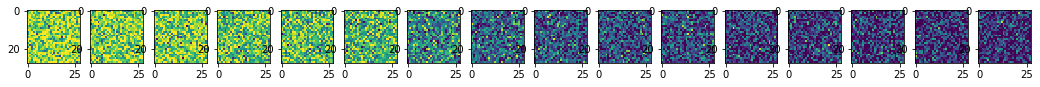

In [76]:
matrices = bitonic_matrices(16)

fig, axs = plt.subplots(1,16, figsize=(18,6))

sorted_xs = comparison_sort(matrices, x, compare_fn, alpha=1, scale=200)

k = 0
for i in range(16):    
        axs[i].imshow(sorted_xs[k,...], vmin=-2, vmax=2)
        k = k + 1


    

## Variance reduction

Because the sorting operation should be invariant to permutations, the error can be reduced very slightly
by running $m$ parallel sorting networks, with each input preceded by a fixed random permutation matrix, and averaging the results. This reduces the error (very) marginally.

```python
        
    def random_permutations(n, m):
        return [np.eye(n)[np.random.permutation(np.arange(n))] for i in range(m)]

    variance_reduced = np.mean([diff_sort(matrices, p @ x) for p in random_permutations(n, m)], axis=0)    
```

In [7]:
np.random.seed(2019)
x = np.random.uniform(-200, 200, 16)
matrices = bitonic_woven_matrices(16)

In [8]:
def random_permutations(n, m):
        return [np.eye(n)[np.random.permutation(np.arange(n))] for i in range(m)]

def variance_reduced(matrices, x, m = 5):
    n = len(x)
    return np.mean([diff_sort_weave(matrices, p @ x) for p in random_permutations(n, m)], axis=0) 

In [9]:
def show_errors(xs, sort_fn):
    truth = np.sort(xs, axis=1)
    sorts = np.stack([sort_fn(x) for x in xs])
    
    plt.imshow(truth-sorts, cmap='RdBu', vmin=-1, vmax=1)
    plt.colorbar()
    plt.axis("off")
    print("RMS error", np.sqrt(np.mean((truth-sorts)**2)))

### Original

RMS error 0.18603505359785322


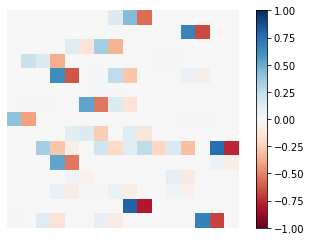

In [10]:
xs = np.random.uniform(-250, 250, (15, 16))
show_errors(xs, lambda x:diff_sort_weave(matrices, x))

### Averaged over 5 permutations

RMS error 0.17300916785269388


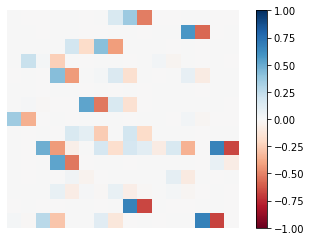

In [18]:
show_errors(xs, lambda x:variance_reduced(matrices, x, m=5))

## Tempering

As well adjustable $\alpha$ parameters in the smoothmax/logsumexp functions, we can also interpolate between sorting and no-sorting, by replacing each permutation matrix $A_i$ with 
$\beta I + (1-\beta A_i)$, for some small $\beta$.

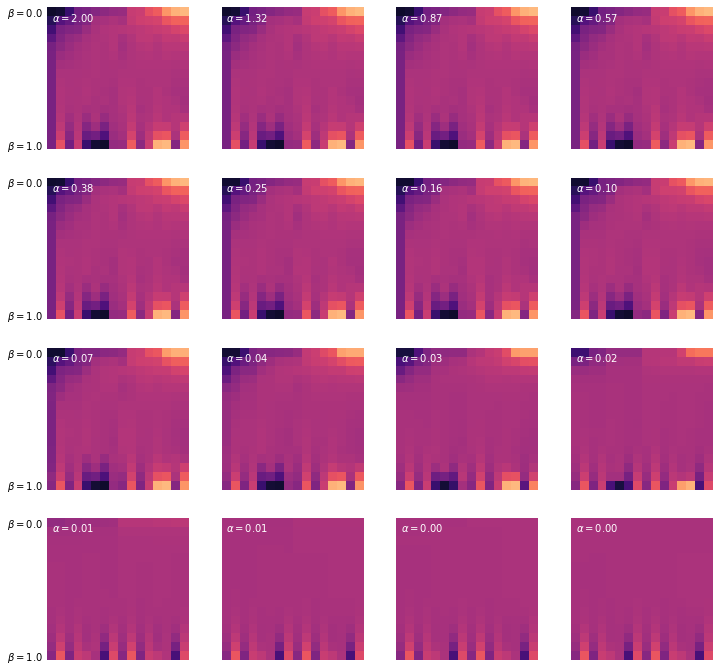

In [63]:
x = np.random.uniform(-250, 250, 16)
matrices = bitonic_woven_matrices(16)

def show_interpolations(matrices, x):
   
    alphas = [2**-alpha-2**-8 for alpha in np.linspace(-1,8,16)]
    sorts =  [[diff_sort_weave(matrices, x, softmax=lambda a,b:smoothmax(a,b,alpha=alpha), 
                                  beta=beta) for beta in np.linspace(0,1,16)] for alpha in alphas]
    
    fig = plt.figure(figsize=(12,12))
    for i,(alpha,alpha_block) in enumerate(zip(alphas, sorts)):
        ax = fig.add_subplot(4,4,i+1)
        ax.imshow(sorts[i], cmap='magma', vmin=-250, vmax=250)
        ax.text(0, 1, f"$\\alpha={alpha:.2f}$", color='white')
        if i%4==0:
            ax.text(-5, 0.5, "$\\beta=0.0$", color='black')
            ax.text(-5, 16-0.5, "$\\beta=1.0$", color='black')

        ax.axis("image")
        ax.axis("off")
show_interpolations(matrices, x)

## Transformations
Any invertible transform can be applied to values before sorting and inverted afterwards. Typically this would be to standardise the variables, and scale the z-scores by a factor of 250 or so:


RMS error 0.6416666150954068


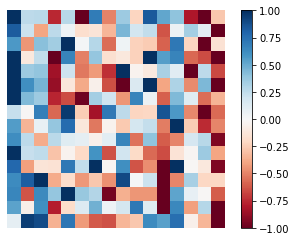

In [23]:
xs = np.random.uniform(-10, 10, (16, 16))
show_errors(xs, lambda x:diff_sort_weave(matrices, x))

RMS error 0.0002203288508864858


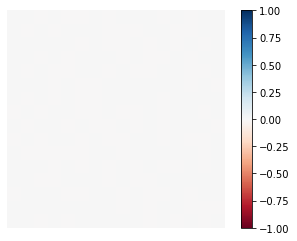

In [24]:
std = (xs - np.mean(xs,axis=1))/ np.std(xs,axis=1)
show_errors(std, lambda x:(diff_sort_weave(matrices, x*250)/250))